# Performance evaluation of GGRBF using Wilson editing
---------------

`Importing necessary packages`

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score
import core.Gabriel_Graph as GG
from core.RBF import RBF
from core.utils import (
    two_classes_scatter,
    wilson_editing,
    plot_decision_surface,
    GGRBF_K_Fold_Performance,
    GGRBF_LOOCV_Accuracy,
    make_xor,
    make_gaussian
)

## 1. Two noisy gaussians on two dimensions
----------

`Generating data`

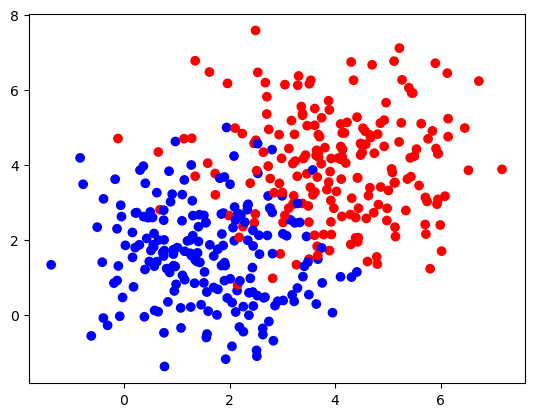

In [2]:
X, y = make_gaussian(200, (1.5,1.5), 1.2, 200, (4,4), 1.4)
X = pd.DataFrame(X)
two_classes_scatter(X, y)

`Visualizing noise removal using Wilson editing`

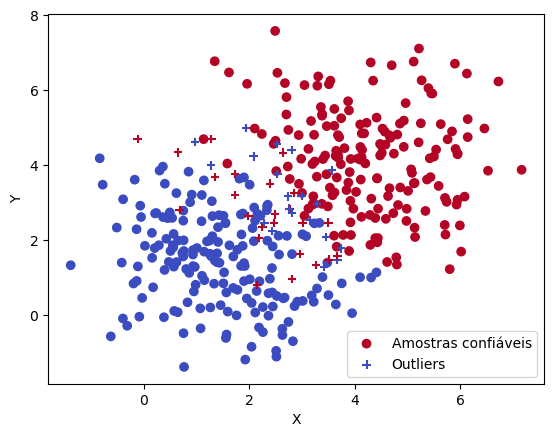

In [3]:
wilson_editing(X, y, k=3, plot=True)

`Train test split`

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

`Building the graph`

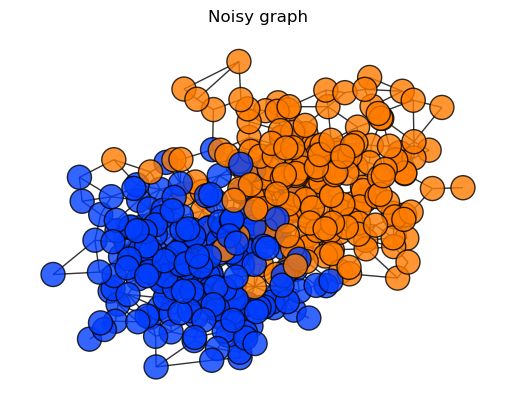

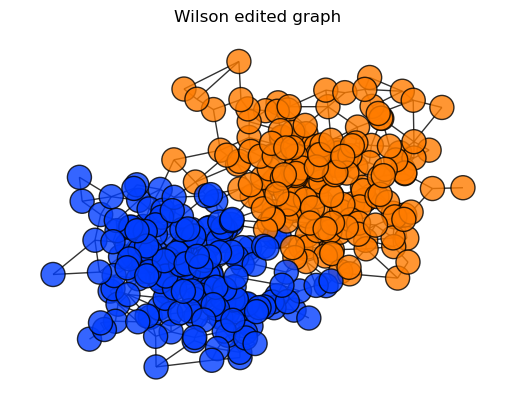

In [8]:
noisy_graph = GG.Gabriel_Graph(X, y)
noisy_graph.build(wilson_editing=False)
plt.title("Noisy graph")
noisy_graph.plot(label=False)

graph = GG.Gabriel_Graph(X, y)
graph.build(wilson_editing=True, k=3)
plt.title("Wilson edited graph")
graph.plot(label=False)


`Calculating and visualizing the centers (SSV)`

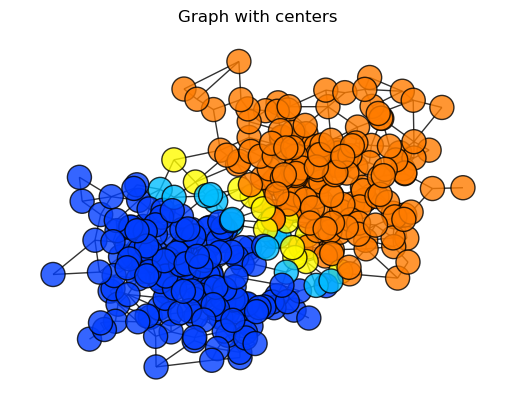

In [13]:
centers = graph.calculate_centers()
plt.title("Graph with centers")
graph.plot(label=False, show_centers=True)

`Using the graph to predict classes via a RBF (Radial Basis Function) network.`

In [14]:
rbf_model = RBF()
rbf_model.fit_model(X_train, y_train, centers, 1, classification=True)

# y_test must be in a {+1, -1} range for comparing it to the predictions
y_test = 2*(y_test)-1

y_hat = rbf_model.predict(X_test, classification=True)

`Evaluating the performance of the model using accuracy and AUC`

In [15]:
acc = accuracy_score(y_test, y_hat)
auc = roc_auc_score(y_test, y_hat)
print(f"Accuracy: {acc*100:.2f}%\nAUC: {auc:.2f}")

Accuracy: 88.75%
AUC: 0.89


`Visualizing the decision surface`

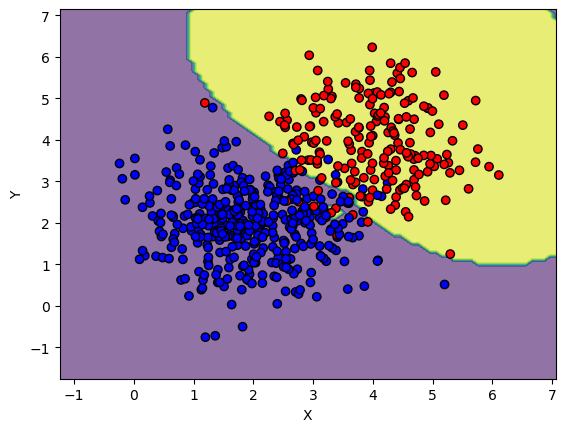

In [38]:
plot_decision_surface(X, y, rbf_model)